# K-Means Cluster Analysis on Stocks Using Python
## Conduct K-Means Cluster Analysis to filter stocks with a volume of over 1 million
In this script, cluster analysis will be performed on a vector of stock tickers extracted from **TD Ameritrade's ThinkorSwim** platform.  

These stocks were already filtered using **ThinkorSwim's Stock Hacker** using two criteria: <u> a volume of over 1 million and a closing price above $\$15</u>.  

Detailed information for each stock will be extracted from TD Ameritrade through its **API** once authentication has been successfully processed using `TDLogin.py` on its developer website.  

From those details, Cluster Analysis will be conducted based on three factors: <u>return on equity, return on assets, and return on investment</u>.  

Stocks with missing values, values of zero (0), and outliers will be eliminated from the analysis.  

Clusters will then be plotted on 3D canvas using original values and scaled values.  

On the minor side note, Cluster Analysis will also be done of the data after it has gone through **Principal Component Analysis (PCA)**. 

Since K-Means will be used, Silhouette Analysis will be used to determine the optimal number of clusters to use.  

For visuals,  package called `yellowbrick` will be used for some of the plots.  

Once Cluster Analysis is processed, each stock in the original data frame will be assigned with its corresponding Cluster ID so that it is known which stocks belong to which cluster and exhibit similar traits.

### 1. Import Packages

In [192]:
import requests
import pandas as pd
from TDLogin import TDconsumerkey

### 2. Input CSV file with a vector of stock tickers
Read a CSV file containing a vector of stock tickers that have already been filtered using Stock Hacker in TD Ameritrade's ThinkorSwim platform.  

Store it as a data frame.  

Although it doesn't appear that the file include any bad characters, future files might, so they are removed.

In [238]:
# Load stock tickers into a data frame
tickers = pd.read_csv(r"C:\Users\cinji\OneDrive\Documents\ThinkOrSwim\Tickers1Mvol.csv")

# Remove bad character
tickers['Symbol'] = tickers['Symbol'].str.replace('^', '')

# Total number of stocks in the original list
display(tickers.shape[0])

708

### 3. Divide stock data frame into chucks of 100 tickers
Dividing the `tickers` data frame into chunks should accelerate the computer processing time.

In [194]:
# Define size of chunk
n = 100

# Break data frame into chunks
tickers_chunk = [tickers[i:i + n] for i in range(0, tickers.shape[0], n)]

### 4. Download stock information using TD Ameritrade API
Using TD Ameritrade's developer API, download fundamental information for each stock

In [195]:
# Define API endpoint
endpoint = r"https://api.tdameritrade.com/v1/instruments"

# Create dictionary
stock_dict = {}

# For each chunk
for chunk in tickers_chunk:
    
    #define payload
    payload = {'apikey':TDconsumerkey,
               'projection':'fundamental', 
               'symbol':list(chunk['Symbol'])}
    
    # Make a request
    content = requests.get(url = endpoint, params = payload)
    
    # Convert JSON string to a dictionary
    data = content.json()
    
    try:
        for stock in data:
            stock_dict[data[stock]['cusip']] = data[stock]['fundamental']
    except:
           continue

### 5. Convert the stock dictionary to a data frame
Converting the stock dictionary to a data frame would make the information more readable

In [196]:
# Convert dictionary to data frame
tickers_df = pd.DataFrame(stock_dict)

tickers_df = tickers_df.transpose()

display(tickers_df.head())
tickers_df.shape

,beta,bookValuePerShare,currentRatio,divGrowthRate3Year,dividendAmount,dividendDate,dividendPayAmount,dividendPayDate,dividendYield,epsChange,...,revChangeYear,sharesOutstanding,shortIntDayToCover,shortIntToFloat,symbol,totalDebtToCapital,totalDebtToEquity,vol10DayAvg,vol1DayAvg,vol3MonthAvg
037612306,1.50074,0,0,0,1.98,2019-08-15 00:00:00.000,0.5,2019-08-30 00:00:00.000,5.57,0,...,0,200.788,0,0,APO,55.8186,232.751,2.04675e+06,2.04845e+06,3.22582e+07
072730302,0.98595,14.8661,1.29061,0,0.78,2019-04-29 00:00:00.000,0.86135,2018-06-11 00:00:00.000,4.27,0,...,0,3730.21,0,0,BAYRY,49.083,96.7661,519189,519190,1.17904e+07
037833100,1.22856,2.79895,1.50465,0,3.08,2019-08-09 00:00:00.000,0.77,2019-11-15 00:00:00.000,1.45,0,...,0,4519.18,0,0,AAPL,52.9194,112.401,2.87812e+07,2.87812e+07,5.52795e+08
030975106,1.11408,0,0.58431,0,3.8,2019-08-08 00:00:00.000,0.95,2019-11-19 00:00:00.000,12.17,0,...,0,92.9997,0,0,APU,85.3897,626.043,1.90490e+06,1.92425e+06,1.59173e+07
056752108,1.72474,33.5663,2.60992,0,0,,0,,0,0,...,0,350.015,0,0,BIDU,27.075,39.9218,6.07849e+06,6.07849e+06,8.41074e+07


(705, 46)

### 6. Select stock parameters that will be used in Cluster Analysis
Since not all of the parameters are important or have much influence in the success of a stock, pick the ones that have the most impact.  

It is most efficient to pick up to only five (5) parameters because adding more does not necessarily make much of a difference, and could potentially overfit the results.

Here, **return on equity, return on assets, and return on investment** were chosen.

>**Return on Equity (ROE):** Measure of financial performance calculated by net income / shareholders' equity. Shareholders' equity = company’s assets - company's debt, so <u>ROE could be thought of as the return on net assets</u>. <font color = blue>*ROE measures how effectively management is at using a company’s assets to create profits.  Target an ROE that is equal to or just above the average for the peer group.*</font>

>**Return on Assets (ROA):** Indicate how profitable a company is relative to its total assets. ROA measures <font color = blue>how efficiently a company's management is at using its assets to generate earnings</font>. Displayed as a percentage.  Takes debt (financial leverage) into account.

>**Return on Investment (ROI):** Evaluates how efficient an investment(s) is. It measure the amount of return on a particular investment, relative to the investment’s cost. Expressed as a percentage or a ratio.  Can be used in conjunction with rate of return.

<font color = red>**However, it would be beneficial to experiment with other parameters.**</font>

In [197]:
# Define indicator list
metrics_list = ['returnOnEquity', 'returnOnAssets', 'returnOnInvestment', 'symbol']

# Select required columns
indicators_df = tickers_df[metrics_list]

# Display new data frame
#display(indicators_df)

# Remove missing values
indicators_df = indicators_df[indicators_df[metrics_list] != 0]
indicators_df = indicators_df.dropna(how = 'any')

# Display cleaned dataset
display(indicators_df.head())
display(indicators_df.shape)

,returnOnEquity,returnOnAssets,returnOnInvestment,symbol
037612306,28.3231,9.18718,14.2916,APO
072730302,1.27723,0.44586,0.55592,BAYRY
037833100,51.6497,16.2622,22.1398,AAPL
030975106,24.8705,4.8393,5.73046,APU
056752108,10.4393,4.25153,5.88639,BIDU


(490, 4)

### 7. Redefine datatypes in the stock data frame
The datatypes of the data frame need to be redefined to ensure subsequent functions can work with it.

It also adds more readability.

In [198]:
# Set index
indicators_df = indicators_df.set_index('symbol')

# Convert data frame to float
indicators_df = indicators_df.astype('float')

indicators_df.head()

,returnOnEquity,returnOnAssets,returnOnInvestment
symbol,,,
APO,28.32311,9.18718,14.29161
BAYRY,1.27723,0.44586,0.55592
AAPL,51.64968,16.26216,22.13981
APU,24.87050,4.83930,5.73046
BIDU,10.43935,4.25153,5.88639


### 8. Exclude outliers
Exclude any outliers within the ROE, ROA, and ROI parameters since these values will throw the results off.

Show how many tickers were eliminated as outliers for each parameter.

<font color = red>**Filter threshold can be adjusted.**</font>

In [199]:
# Define filters
roe_filter = indicators_df.iloc[:, 0] < 40
roa_filter = indicators_df.iloc[:, 1] < 30
roi_filter = indicators_df.iloc[:, 2] < 30

# Get counts for each column
roe_count = pd.Series(roe_filter).value_counts()
roa_count = pd.Series(roa_filter).value_counts()
roi_count = pd.Series(roi_filter).value_counts()

# Display results
display(roe_count)
display(roa_count)
display(roi_count)

True     431
False     59
Name: returnOnEquity, dtype: int64

True     487
False      3
Name: returnOnAssets, dtype: int64

True     478
False     12
Name: returnOnInvestment, dtype: int64

#### Interpretation
Of the 490 stocks left over, 59 had returns on equity over 40.

Three had returns on asset over 30.

Twelve had returns on investment over 30.

These are considered outliers for each parameter.

### 9. Eliminate outliers from the stock data frame
Eliminate stock tickers with ROE, ROA, and ROI that are considered outliers from the stock data frame.

In [200]:
# Filter entire data frame
indicators_df = indicators_df[roe_filter & roa_filter & roi_filter]

display(indicators_df.head())
indicators_df.shape

,returnOnEquity,returnOnAssets,returnOnInvestment
symbol,,,
APO,28.32311,9.18718,14.29161
BAYRY,1.27723,0.44586,0.55592
APU,24.87050,4.83930,5.73046
BIDU,10.43935,4.25153,5.88639
AAXN,3.25261,2.19634,2.76237


(429, 3)

#### Interpretation
Of the 490 stocks, 61 stocks had outliers on all three (3) parameters, leaving 429 of them for Cluster Analysis.

### 10. Create a statistical summary of the stock data frame
Create a statistical summary of the stock data frame before conducting Cluster Analysis on it.

This summary includes:
- Number of stocks
- Mean value of each parameter
- Standard deviation of each parameter
- Minimum value
- 25% Quantile value
- 50% Quantile value
- 75% Quantile value
- Maximum value
- +3 Standard Deviation value
- -3 Standard Deviation value

In [201]:
# Create statistical summary
describe_df = indicators_df.describe()

# Add standard deviation metric
describe_df.loc['+3_std'] = describe_df.loc['mean'] + (describe_df.loc['std'] * 3)
describe_df.loc['-3_std'] = describe_df.loc['mean'] - (describe_df.loc['std'] * 3)

describe_df

,returnOnEquity,returnOnAssets,returnOnInvestment
count,429.000000,429.000000,429.000000
mean,15.255368,6.295303,8.181943
std,9.279902,4.746151,6.046645
min,0.011110,0.005700,0.006090
25%,8.189910,2.929040,3.677230
50%,13.539220,5.212030,6.592940
75%,21.196600,8.645850,10.995140
max,39.858650,23.995760,29.877380
+3_std,43.095074,20.533757,26.321880
-3_std,-12.584338,-7.943151,-9.957993


### 11. Plot stock data on a 3D canvas
Plot the stock tickers on a 3D canvas where the axis are x = ROE, y = ROA, and z = ROI

Plot is rotated in several angles to present visibility and perspective.

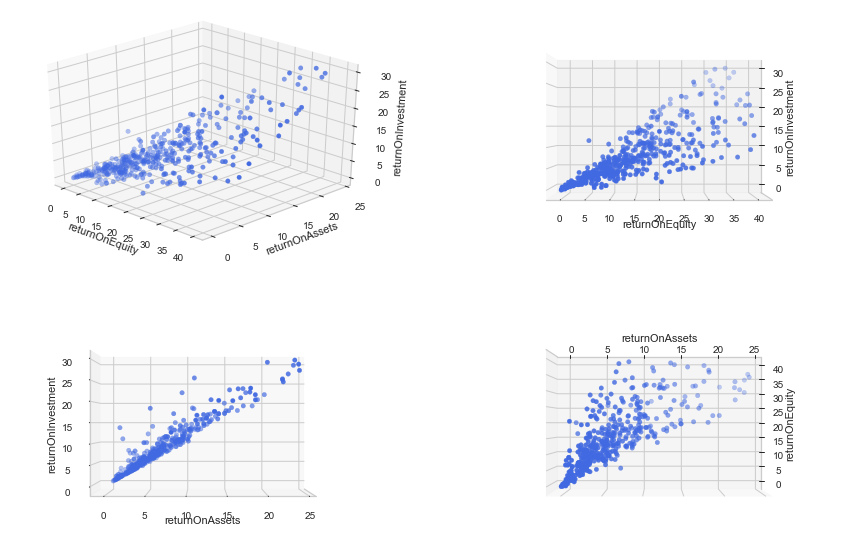

In [202]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define figure
fig = plt.figure(figsize = (15,10))

##########################################################################################
# First plot
##########################################################################################

# Assign a subplot
ax1 = fig.add_subplot(2, 2, 1, projection = '3d')

# Define x, y, and z axis
x1 = list(indicators_df.iloc[:,0])
y1 = list(indicators_df.iloc[:,1])
z1 = list(indicators_df.iloc[:,2])

# Define axis labels
column_names = indicators_df.columns
ax1.set_xlabel(column_names[0])
ax1.set_ylabel(column_names[1])
ax1.set_zlabel(column_names[2])

# Define markers and colors
ax1.scatter(x1, y1, z1, c = 'royalBlue', marker = 'o')

# Orient graph for overall look
ax1.view_init(30, 315)

##########################################################################################
# Second plot
##########################################################################################

# Assign a subplot
ax2 = fig.add_subplot(2, 2, 2, projection = '3d')

# Define x, y, and z axis
x2 = list(indicators_df.iloc[:,0])
y2 = list(indicators_df.iloc[:,1])
z2 = list(indicators_df.iloc[:,2])

# Define axis labels
column_names = indicators_df.columns
ax2.set_xlabel(column_names[0])
ax2.set_zlabel(column_names[2])

# Define markers and colors
ax2.scatter(x2, y2, z2, c = 'royalBlue', marker = 'o')

# Remove y (ROA) label and ticks
plt.yticks([], [])

# Orient graph to display ROI vs. ROE
ax2.view_init(0, 270)

##########################################################################################
# Third plot
##########################################################################################

# Assign a subplot
ax3 = fig.add_subplot(2, 2, 3, projection = '3d')

# Define x, y, and z axis
x3 = list(indicators_df.iloc[:,0])
y3 = list(indicators_df.iloc[:,1])
z3 = list(indicators_df.iloc[:,2])

# Define axis labels
column_names = indicators_df.columns
ax3.set_ylabel(column_names[1])
ax3.set_zlabel(column_names[2])

# Define markers and colors
ax3.scatter(x3, y3, z3, c = 'royalBlue', marker = 'o')

# Remove y (ROE) label and ticks
plt.xticks([], [])

# Orient graph to display ROI vs. ROA
ax3.view_init(0, 0)

##########################################################################################
# Fourth plot
##########################################################################################

# Assign a subplot
ax4 = fig.add_subplot(2, 2, 4, projection = '3d')

# Define x, y, and z axis
x4 = list(indicators_df.iloc[:,0])
y4 = list(indicators_df.iloc[:,1])
z4 = list(indicators_df.iloc[:,2])

# Define axis labels
column_names = indicators_df.columns
ax4.set_xlabel(column_names[0])
ax4.set_ylabel(column_names[1])

# Define markers and colors
ax4.scatter(x4, y4, z4, c = 'royalBlue', marker = 'o')

# Remove y (ROI) label and ticks
ax4.set_zticklabels([])
ax4.set_zticks([])

# Orient graph to display ROE vs. ROA
ax4.view_init(270, 0)

plt.show()

#### Interpretation
The 3-dimensional plot seemed difficult to interpret because of the lack of depth in the graph.  Therefore, 2-dimensional graphs were also plotted.

Based on the resulting plots, it was clear that ROA was strongly correlation to ROI.

For the other two (2) comparisons, they were positively correlated.  However, both showed extreme heteroscedasticity.

### 12. Normalize the values of the stocks
Rescale ROE, ROA, and ROI for the stock data frame.  

Robust scaler will be used.  This scaler removes the median and scales the data to the Interquantile range (IQR: 1st and 3rd quantile).

Plot the stocks after it has been rescaled using robust scaling.

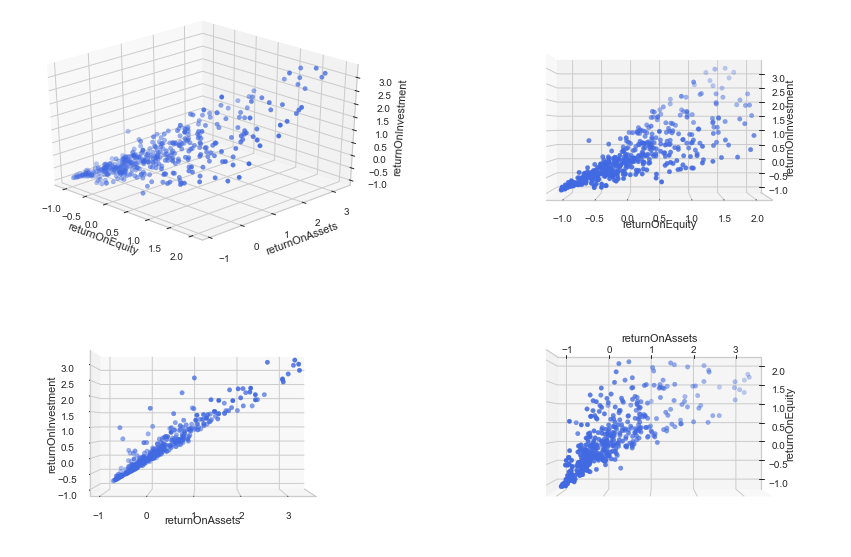

In [209]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# Define each scaler
min_max_scaler = MinMaxScaler()
std_scaler = StandardScaler()
robust_scaler = RobustScaler()

# Scale data
X_train_minmax = min_max_scaler.fit_transform(indicators_df)
X_train_standard = std_scaler.fit_transform(indicators_df)
X_train_robust = robust_scaler.fit_transform(indicators_df)

# Define figure
fig = plt.figure(figsize = (15,10))

##########################################################################################
# First plot
##########################################################################################

# Assign a subplot
ax1 = fig.add_subplot(2, 2, 1, projection = '3d')

# Define x, y, and z axis
x1 = X_train_robust[:,0]
y1 = X_train_robust[:,1]
z1 = X_train_robust[:,2]

# Define axis labels
column_names = indicators_df.columns
ax1.set_xlabel(column_names[0])
ax1.set_ylabel(column_names[1])
ax1.set_zlabel(column_names[2])

# Define markers and colors
ax1.scatter(x1, y1, z1, c = 'royalBlue', marker = 'o')

# Orient graph for overall look
ax1.view_init(30, 315)

##########################################################################################
# Second plot
##########################################################################################

# Assign a subplot
ax2 = fig.add_subplot(2, 2, 2, projection = '3d')

# Define x, y, and z axis
x2 = X_train_robust[:,0]
y2 = X_train_robust[:,1]
z2 = X_train_robust[:,2]

# Define axis labels
column_names = indicators_df.columns
ax2.set_xlabel(column_names[0])
ax2.set_zlabel(column_names[2])

# Define markers and colors
ax2.scatter(x2, y2, z2, c = 'royalBlue', marker = 'o')

# Remove y (ROA) label and ticks
plt.yticks([], [])

# Orient graph to display ROI vs. ROE
ax2.view_init(0, 270)

##########################################################################################
# Third plot
##########################################################################################

# Assign a subplot
ax3 = fig.add_subplot(2, 2, 3, projection = '3d')

# Define x, y, and z axis
x3 = X_train_robust[:,0]
y3 = X_train_robust[:,1]
z3 = X_train_robust[:,2]

# Define axis labels
column_names = indicators_df.columns
ax3.set_ylabel(column_names[1])
ax3.set_zlabel(column_names[2])

# Define markers and colors
ax3.scatter(x3, y3, z3, c = 'royalBlue', marker = 'o')

# Remove y (ROE) label and ticks
plt.xticks([], [])

# Orient graph to display ROI vs. ROA
ax3.view_init(0, 0)

##########################################################################################
# Fourth plot
##########################################################################################

# Assign a subplot
ax4 = fig.add_subplot(2, 2, 4, projection = '3d')

# Define x, y, and z axis
x4 = X_train_robust[:,0]
y4 = X_train_robust[:,1]
z4 = X_train_robust[:,2]

# Define axis labels
column_names = indicators_df.columns
ax4.set_xlabel(column_names[0])
ax4.set_ylabel(column_names[1])

# Define markers and colors
ax4.scatter(x4, y4, z4, c = 'royalBlue', marker = 'o')

# Remove y (ROI) label and ticks
ax4.set_zticklabels([])
ax4.set_zticks([])

# Orient graph to display ROE vs. ROA
ax4.view_init(270, 0)

plt.show()

### 13. Conduct Principal Component Analysis
Principal Component Analysis determines how much of the data would be explained by how many parameter.

Because this dataset is relatively small, this analysis is insignificant (the results will show that one parameter will explain over 98% of the data).

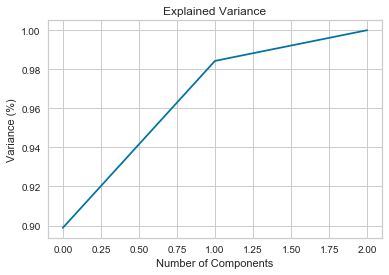

In [46]:
# Principal Component Analysis

from sklearn.decomposition import PCA
import numpy as np

# Pass through scaled data
pca = PCA().fit(X_train_robust)

# Plot cumulative summation of explained variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))

# Define titles and labels
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Explained Variance')

#Show plot
plt.show()

#### Interpretation
On a side note, PCA indicated that the more than 98% of the data could be explained by only one (1) parameter/component.

### 14. Generate values based on results from PCA

In [47]:
# Create a PCA modified dataset
pca_dataset = PCA(n_components = 2).fit(X_train_robust).transform(X_train_robust)

# Store it in a new data frame
pca_dataset = pd.DataFrame(data = pca_dataset, columns = ['component 1', 'component 2'])

pca_dataset.head()

,component 1,component 2
0,1.318150,0.453713
1,-1.794222,-0.249783
2,-0.007959,0.845023
3,-0.095504,-0.034735
4,-1.343671,-0.320944


### 15. Plot data based on results from PCA

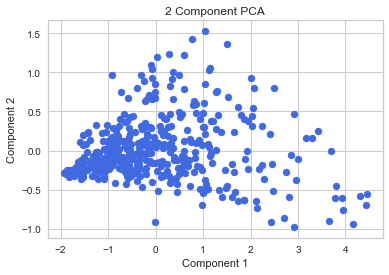

In [48]:
# Plot figure
plt.figure()

# Define titles and labels
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('2 Component PCA')

# Plot scatter plot
plt.scatter(pca_dataset['component 1'], pca_dataset['component 2'], c = 'royalBlue', s = 50)

### 16. Conduct Silhouette Analysis to determine the optimal number of clusters to use for the stock dataset
Use Silhouette Analysis to determine the number of optimal clusters to use on the stock dataset when conducting K-Means Clustering.

This analysis will test up to ten (10) clusters.

The higher the score the better.

>**Score thresholds:**
>>**0.60 $<$ Score:** Excellent

>>**0.40 $<$ Score $<$ 0.60:** OK (There might be something there.)

>>**Score $<$ 0.40:** Bad

In [49]:
from sklearn.cluster import KMeans
from sklearn import metrics

# Silhouette analysis indicates the optimal number of clusters.  The higher the better.

# Create a dictionary to store scores
results_dict = {}

# Define the number of iterations desired
num_of_clusters = 10

# Run through each k
for k in range(2, num_of_clusters):
    
    print('-' * 100)
    
    # Define the key for this iteration
    results_dict[k] = {}
    
    # Create an instance of the kmeans model
    kmeans = KMeans(n_clusters = k, random_state = 0).fit(X_train_robust)
    
    # Define silhouette score
    sil_score = metrics.silhouette_score(X_train_robust, kmeans.labels_, metric = 'euclidean')
    
    # Store different metrics
    results_dict[k]['silhouette_score'] = sil_score
    results_dict[k]['intertia'] = kmeans.inertia_
    results_dict[k]['score'] = kmeans.score
    results_dict[k]['model'] = kmeans
    
    #print results
    print("The number of clusters: {}".format(k))
    print("Silhouette Score: {}".format(sil_score))

----------------------------------------------------------------------------------------------------
The number of clusters: 2
Silhouette Score: 0.5367647287240787
----------------------------------------------------------------------------------------------------
The number of clusters: 3
Silhouette Score: 0.467844044587781
----------------------------------------------------------------------------------------------------
The number of clusters: 4
Silhouette Score: 0.41028724382252074
----------------------------------------------------------------------------------------------------
The number of clusters: 5
Silhouette Score: 0.37329040393311863
----------------------------------------------------------------------------------------------------
The number of clusters: 6
Silhouette Score: 0.3850855248642635
----------------------------------------------------------------------------------------------------
The number of clusters: 7
Silhouette Score: 0.35777516449359903
--------------

#### Interpretation
Since the data and the analysis did not produce a Silhouette Score above 0.60 for the optimal number of clusters, the highest numbers were used.

That would mean Cluster Analysis would be done for two (2) and three (3) clusters.

### 17. Use the Yellowbrick package to plot the Silhouette Score
Plot the Silhouette Scores to understand and confirm the numeric results.

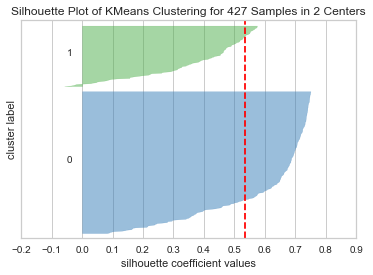

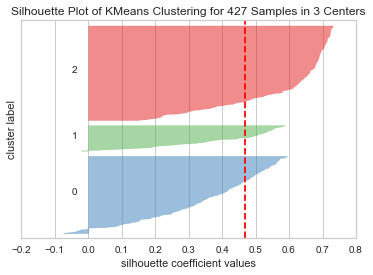

In [50]:
from yellowbrick.cluster import SilhouetteVisualizer

clusters = [2, 3]

for cluster in clusters:
    
    # Create an instance of kmeans model
    kmeans = KMeans(n_clusters = cluster, random_state = 0)
    
    # Pass model through visualizer
    visualizer = SilhouetteVisualizer(kmeans)
    
    # Fit data
    visualizer.fit(X_train_robust)
    
    # Show chart
    visualizer.poof()

#### Interpretation
Silhouette plots showed the proportion of data points that would be included in each cluster.  Ideally, each color coded area would be the same size.  Any areas that landed in the negative coefficent values section meant that the data point could potentially be categorized into more than one (1) cluster.

The first plot showed what would happen when two (2) clusters were used.  Evidently, a vast majority of the stocks would be included in one (1) cluster.

For three (3) clusters, one (1) cluster still include majority of the stocks, but it was slightly more evened out.

### 18. Construct the cluster plots with the optimal number of clusters
The data points are plotted in a 3D graph using the optimal number of clusters determined by Silhouette Analysis (in this case, 2 or 3).

Unlike the previous plots, the data points are color coded to show to which cluster each point belongs.

The red piont (<font color = red>**x**</font>) indicates the center of each cluster along with the coordinates.

----------------------------------------------------------------------------------------------------


array([-0.20481387,  0.90648544])

array([-0.24108292,  1.1798049 ])

array([-0.21474886,  1.2104809 ])

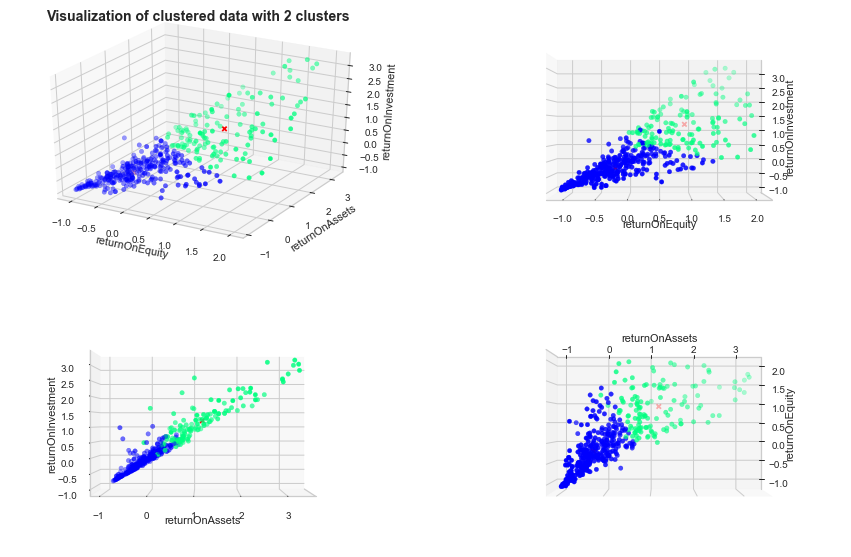

----------------------------------------------------------------------------------------------------


array([-0.43431533,  0.47656532,  1.15880687])

array([-0.41223016,  0.37016069,  1.82423144])

array([-0.40971196,  0.43587853,  1.83073417])

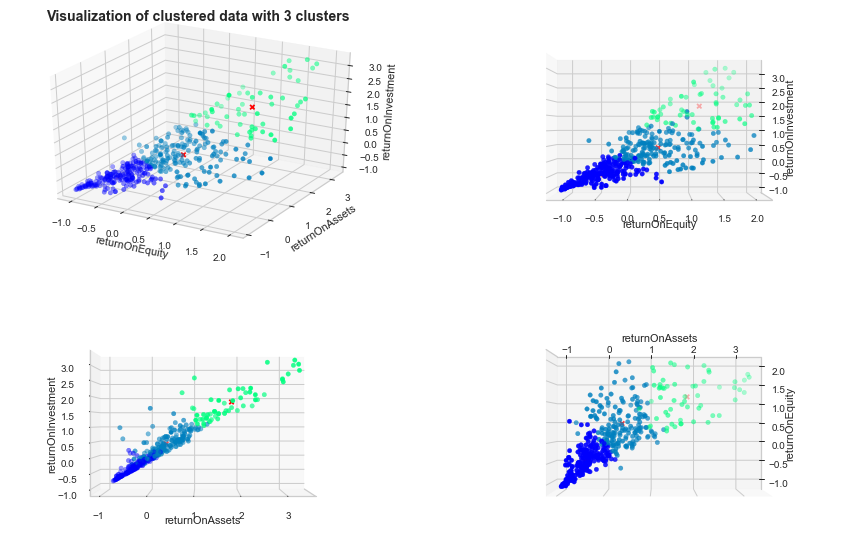

In [243]:
clusters = [2, 3]

for cluster in clusters:
    
    print("-" * 100)
    
    # Create an instance of kmeans model
    kmeans = KMeans(n_clusters = cluster, random_state = 0).fit(X_train_robust)
    
    # Define cluster centers
    cluster_centers = kmeans.cluster_centers_
    C1 = cluster_centers[:, 0]
    C2 = cluster_centers[:, 1]
    C3 = cluster_centers[:, 2]
    
    display(C1, C2, C3)

    # Define figure
    fig = plt.figure(figsize = (15,10))
    
    ##########################################################################################
    # First plot
    ##########################################################################################

    # Assign a subplot
    ax1 = fig.add_subplot(2, 2, 1, projection = '3d')

    # Define title
    plt.title("Visualization of clustered data with {} clusters".format(cluster), fontweight = 'bold', fontsize = 14)

    # Define x, y, and z axis
    x1 = X_train_robust[:,0]
    y1 = X_train_robust[:,1]
    z1 = X_train_robust[:,2]

    # Define axis labels
    column_names = indicators_df.columns
    ax1.set_xlabel(column_names[0])
    ax1.set_ylabel(column_names[1])
    ax1.set_zlabel(column_names[2])

    # Define markers and colors
    ax1.scatter(x1, y1, z1, c = kmeans.labels_.astype(float), cmap = 'winter', marker = 'o')
    ax1.scatter(C1, C2, C3, marker = 'x', color = 'red')
    
    ##########################################################################################
    # Second plot
    ##########################################################################################

    # Assign a subplot
    ax2 = fig.add_subplot(2, 2, 2, projection = '3d')

    # Define x, y, and z axis
    x2 = X_train_robust[:,0]
    y2 = X_train_robust[:,1]
    z2 = X_train_robust[:,2]

    # Define axis labels
    column_names = indicators_df.columns
    ax2.set_xlabel(column_names[0])
    ax2.set_zlabel(column_names[2])

    # Define markers and colors
    ax2.scatter(x2, y2, z2, c = kmeans.labels_.astype(float), cmap = 'winter', marker = 'o')
    ax2.scatter(C1, C2, C3, marker = 'x', color = 'red')

    # Remove y (ROA) label and ticks
    plt.yticks([], [])

    # Orient graph to display ROI vs. ROE
    ax2.view_init(0, 270)

    ##########################################################################################
    # Third plot
    ##########################################################################################

    # Assign a subplot
    ax3 = fig.add_subplot(2, 2, 3, projection = '3d')

    # Define x, y, and z axis
    x3 = X_train_robust[:,0]
    y3 = X_train_robust[:,1]
    z3 = X_train_robust[:,2]

    # Define axis labels
    column_names = indicators_df.columns
    ax3.set_ylabel(column_names[1])
    ax3.set_zlabel(column_names[2])

    # Define markers and colors
    ax3.scatter(x3, y3, z3, c = kmeans.labels_.astype(float), cmap = 'winter', marker = 'o')
    ax3.scatter(C1, C2, C3, marker = 'x', color = 'red')

    # Remove x (ROE) label and ticks
    plt.xticks([], [])

    # Orient graph to display ROI vs. ROE
    ax3.view_init(0, 0)

    ##########################################################################################
    # Fourth plot
    ##########################################################################################

    # Assign a subplot
    ax4 = fig.add_subplot(2, 2, 4, projection = '3d')

    # Define x, y, and z axis
    x4 = X_train_robust[:,0]
    y4 = X_train_robust[:,1]
    z4 = X_train_robust[:,2]

    # Define axis labels
    column_names = indicators_df.columns
    ax4.set_xlabel(column_names[0])
    ax4.set_ylabel(column_names[1])

    # Define markers and colors
    ax4.scatter(x4, y4, z4, c = kmeans.labels_.astype(float), cmap = 'winter', marker = 'o')
    ax4.scatter(C1, C2, C3, marker = 'x', color = 'red')

    # Remove y (ROI) label and ticks
    ax4.set_zticklabels([])
    ax4.set_zticks([])

    # Orient graph to display ROE vs. ROA
    ax4.view_init(270, 0)

    
    plt.show()

#### Interpretation
The cluster plots clarified the results created by the Silhouette Analysis.

It was clear that majority of the stocks bunched up in the lower end of the plots.  Among the stocks included in the total list, these performed the worst.

The middle included stocks that might have performed well in one (1) or two (2) of the parameters, but not all three (3).

The best performers landed in the smallest cluster.  This truly singled them out.

### 19. Assign cluster identity back into the original list of stocks
Add a new column to the filtered original list of stocks, `indicators_df`, with the cluster assignments.

That way, each cluster would include a list of stocks that belong to it.

In [237]:
# Collect cluster assignments from the analysis
indicators_df["ClusterID"] = kmeans.labels_

# List stocks in Cluster 1, the worst of the bunch
Cluster1 = indicators_df[indicators_df["ClusterID"] == 0]
display(Cluster1.head())
display(Cluster1.shape[0])

# List stocks in Cluster 2, those doing okay
Cluster2 = indicators_df[indicators_df["ClusterID"] == 1]
display(Cluster2.head())
display(Cluster2.shape[0])

# List stocks in Cluster 3, the rockstars
Cluster3 = indicators_df[indicators_df["ClusterID"] == 2]
display(Cluster3)
display(Cluster3.shape[0])

,returnOnEquity,returnOnAssets,returnOnInvestment,ClusterID
symbol,,,,
BAYRY,1.27723,0.44586,0.55592,0
BIDU,10.43935,4.25153,5.88639,0
AAXN,3.25261,2.19634,2.76237,0
ATUS,9.12282,0.91222,0.99275,0
AL,11.35344,2.92197,3.15180,0


205

,returnOnEquity,returnOnAssets,returnOnInvestment,ClusterID
symbol,,,,
APO,28.32311,9.18718,14.29161,1
APU,24.87050,4.83930,5.73046,1
BBL,16.80605,8.94510,10.76533,1
AYX,15.95078,7.03728,11.35145,1
AAP,13.05318,4.75887,7.88518,1


167

,returnOnEquity,returnOnAssets,returnOnInvestment,ClusterID
symbol,,,,
A,23.43465,12.85495,15.22255,2
AMAT,38.59179,15.71631,20.17424,2
ALGN,32.18756,20.08147,29.44683,2
ANET,34.61624,23.43945,29.87738,2
ADBE,28.77422,15.39717,22.90467,2
AOS,24.44290,13.49007,17.73774,2
APH,31.44613,12.45613,16.03917,2
CARG,25.79090,17.46142,22.27715,2
CMI,32.14996,13.05624,20.48632,2


57

### Final Conclusive Interpretation
From a total list of 708 stocks, the analysis reduced it down to 57 stocks that landed in the cluster categorized as the "Rockstar".

Before doing actual Cluster Analysis, the process filtered out all stocks that had missing or invalid values.

The parameters used to evaluate the stocks were return on equity, return on assets, and return on investment.  Further filtering was done to eliminate outliers within those parameters.

This resulting list was then finally put through K-Means Cluster Analysis, which included Silhouette Analysis to determine the optimal number of clusters.

The optimal number of clusters turn out to be two (2) or three (3).  Truthfully, neither of those number appeared to be optimal; however, they did score the highest when analyzed up to 10 clusters.

Although two (2) clusters did received the highest Silhouette Score, three (3) clusters were used to make the final conclusion because it might truly single out the stocks with the best performance.

<font color = red>**Unfortunately, only a few stocks showed attractive candlestick charts when checked on ThinkorSwim.  Many of the price history time series charts appeared volatile or declining.**</font>

<u>Therefore, further analysis is needed to determine which stocks would be the best to invest.</u>

**Next steps:**
- Try other parameters besides ROE, ROA, and ROI
- Check 2 clusters instead of 3
- Consider doing Factor Analysis to reduce the number of parameters
- Add an filter original list to include those that give dividends

### Appx. Create test data then predict which cluster it belongs

In [21]:
# Grab model
kmeans = results_dict[3]['model']

# Define some test data
test_data = [[0.10, 3.10, 5.20],
             [0.60, 5.10, 2.20]]

# Make some predictions
kmeans = predict(test_data)

array([1, 1])